### Word Cloud 만들기

```markdown
* 팀 활동 요구사항
제공된 데이터셋과 유사한 데이터셋을 웹 스크레이핑을 통해 만든 다음, word cloud를 만들어 봅시다.
데이터셋을 만들 때 어떤 작업들이 추가적으로 필요할까요?
prototyping에는 최소 1,000개 이상의 데이터를 사용하세요.
해당 분석을 통해 어떤 비즈니스 가치를 만들 수 있을지에 대해 토의합시다.
```

### 절차
<aside>
💡1. 웹 스크래핑을 통한 데이터 추출 → CSV 형태로 저장 (Extract → Load)<br>
💡2. CSV 파일을 읽어 전처리 하여 Word Cloud 생성 (Transform, Analyze)
</aside>

### 프로토타이핑
- 사용할 데이터 셋 : 네이버 웹툰 댓글
- 데이터셋을 만들 때 필요한 작업 : Sentiment 수준에 대한 정보를 함께 다뤄야 합니다.
    - 댓글의 공감/비공감 수치를 통해 감정 분석을 진행함 여러가지 방법이 있을 수 있음


```markdown
[방법1]
(공감 - 비공감) > 0 인 경우 긍정으로 분류
(공감 - 비공감) < 0 인 경우 부정으로 분류
이외에는 중립

[방법2]
(공감 - 비공감) > 0 인 경우 긍정으로 분류, |공감 - 비공감| 만큼 가중치
(공감 - 비공감) < 0 인 경우 부정으로 분류, |공감 - 비공감| 만큼 가중치
이외에는 중립
```

In [9]:
# 필요한 라이브러리 임포트
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from selenium import webdriver
from selenium.webdriver.common.by import By
import time
import re
import os

In [10]:
# df = pd.DataFrame(columns=['text', 'pos', 'neg', 'distance'])
# df.to_csv("webtoon_data.csv", index=False)

In [11]:
"""
path는 해당 웹툰의 링크를 넣으면 됩니다.
이 함수는 댓글이 있는 하나의 화에 해당하는 내용입니다.
이 함수를 호출하는 상위 레이어는 여러 웹툰, 여러 회차에 대해서 DataProduct를 만들 수 있습니다.
그러므로 Product를 생산하는 최소의 단위로 작동하는 함수입니다.
"""
def crawl_comment_from_webtoon(path : str):
    data = []
    
    driver = webdriver.Chrome()
    driver.get(path)
    time.sleep(0.1)
    
    clean_bot_option = driver.find_element(By.CLASS_NAME, "u_cbox_cleanbot_setbutton")
    clean_bot_option.click()
    time.sleep(0.1)
    
    clean_bot_off = driver.find_element(By.ID, "cleanbot_dialog_checkbox_cbox_module")
    clean_bot_off.click()
    time.sleep(0.1)
    
    clean_bot_admit_button = driver.find_element(By.CLASS_NAME, "u_cbox_layer_cleanbot2_extrabtn")
    clean_bot_admit_button.click()
    time.sleep(0.1)
    
    sort_all_comment = driver.find_element(By.ID, "cbox_module_wai_u_cbox_sort_option_tab2")
    sort_all_comment.click()
    time.sleep(0.1)
    
    cbox_btn_more = driver.find_element(By.CLASS_NAME, "u_cbox_btn_more")
    
    # try exception으로 해결하시고
    cnt = 0
    try:
        while True:
            cbox_btn_more.click()
            cnt += 1
            time.sleep(0.5)
        
    except:
        pass
        
        
    comment_list_container = driver.find_element(By.CLASS_NAME, "u_cbox_list")
    comment_list = comment_list_container.find_elements(By.TAG_NAME, "li")
    for li in comment_list:
        deleted = []
        deleted = li.find_elements(By.CLASS_NAME, "u_cbox_type_delete")
        if deleted:
            continue
        
        str_comment_text = li.find_element(By.CLASS_NAME, "u_cbox_contents").text
        int_pos_score = int(li.find_element(By.CLASS_NAME, "u_cbox_cnt_recomm").text)
        int_neg_score = int(li.find_element(By.CLASS_NAME, "u_cbox_cnt_unrecomm").text)
        distance = int_pos_score - int_neg_score
        reply_component = li.find_element(By.CLASS_NAME, "u_cbox_btn_reply")
        data.append([str_comment_text,int_pos_score, int_neg_score, distance])
    
    df = pd.DataFrame(data, columns=['text', 'pos', 'neg', 'distance'])
    df.to_csv("webtoon_data.csv", mode='a', header=False, index=False)
    # df.to_csv("webtoon_data.csv", index=False)
    print(df)
    
# for i in range(125,110,-1):   
#     crawl_comment_from_webtoon(f'https://comic.naver.com/webtoon/detail?titleId=769209&no={i}&week=wed')

In [12]:
from collections import Counter
from konlpy.tag import Okt

In [13]:
# 데이터셋 불러오기 (csv 파일 경로를 지정)
df = pd.read_csv('webtoon_data.csv', encoding='utf-8')

# 데이터프레임 컬럼 명 설정
df.columns = ['text', 'pos', 'neg', 'distance']

# 긍정 및 부정 트윗 필터링
positive_comments = df[df['distance'] > 0]['text']
negative_comments = df[df['distance'] < 0]['text']

In [14]:
okt = Okt()

# 한국어 불용어 리스트 (필요에 따라 직접 추가)
stop_words = set(['의', '가', '이', '은', '들', '을', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다', '아', '서', '게' ,'다' ,'잔' ,'화' ,'외' ,'거'])

def preprocess(text):
    text = re.sub(r'ㅋ+', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)  # 특수 문자 제거
    text = re.sub(r'\d+', '', text)  # 숫자 제거
    tokens = okt.morphs(text)
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

# def preprocess_text(text: str) -> str:
#     # 텍스트 전처리
#     text.replace
#     text = re.sub(r'[^\w\s]', '', text)  # 특수 문자 제거
#     text = re.sub(r'\d+', '', text)  # 숫자 제거
#     # 불용어 제거
#     okt = Okt()
#     tokens = okt.pos(text, norm=True, stem=True)
#     words = [word for word, pos in tokens if pos in ['Noun', 'Verb', 'Adjective']]
#     return words

In [15]:
positive_tokens = positive_comments.apply(preprocess)
negative_tokens = negative_comments.apply(preprocess)

In [16]:
# 단어 샘플링 함수
from collections import Counter

def sample_words(tokens, max_words=100):
    all_words = [word for tokens_list in tokens for word in tokens_list]
    word_counts = Counter(all_words)
    most_common_words = word_counts.most_common(max_words)
    return dict(most_common_words)

positive_word_freq = sample_words(positive_tokens)
negative_word_freq = sample_words(negative_tokens)
print(os.getcwd()+"/AppleGothic.ttf")
# Word Cloud 생성 함수
def create_wordcloud(word_freq, title):
    font_path = os.getcwd()+"/AppleGothic.ttf"
    wordcloud = WordCloud(font_path=font_path, width=800, height=400, max_words=200, background_color='white').generate_from_frequencies(word_freq)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.show()

/Users/admin/Desktop/HMG_W2/missions/W2/M5/AppleGothic.ttf


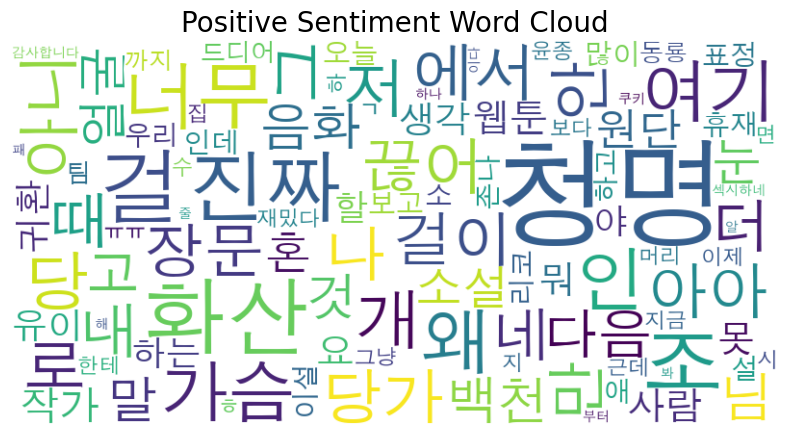

{'청명': 1119, '화산': 457, '걸': 451, '조': 430, '진짜': 395, '너무': 362, '왜': 357, '인': 324, '여기': 305, '개': 290, '가슴': 288, '당': 281, '안': 264, '아니': 262, '저': 259, '에서': 253, '로': 251, '끊어': 246, '때': 243, '만': 237, '나': 236, '아아': 234, '당가': 231, '그': 229, '장문': 224, '걸이': 222, '내': 221, '네': 213, '더': 211, '다음': 209, '님': 202, '고': 191, '말': 185, '백천': 182, '음화': 182, '것': 181, '얼굴': 180, '눈': 175, '소설': 170, '혼': 165, '원단': 163, '작가': 153, '요': 147, '웹툰': 147, '사람': 142, '뭐': 141, '귀환': 140, '못': 138, '생각': 138, '유이': 138, '할': 137, '하는': 133, '야': 130, '휴재': 130, '많이': 128, '애': 126, '인데': 126, '오늘': 126, '보고': 125, '표정': 125, '존나': 124, '설': 124, '소': 123, '리코': 122, '이설': 121, '하고': 116, '우리': 115, '드디어': 115, '팀': 115, '까지': 110, '동룡': 109, '재밌다': 109, '지금': 108, '수': 108, '하': 106, 'ㅠㅠ': 105, 'ㄱ': 104, '면': 104, '집': 103, '시': 103, 'ㅎ': 103, '지': 99, '이제': 97, '그냥': 96, '한테': 96, '머리': 96, '윤종': 96, '보다': 94, '근데': 94, '감사합니다': 93, '하나': 93, '알': 90, '부터': 88, '패': 87, '줄': 86, '해':

In [17]:
# 긍정 및 부정 감정에 대한 Word Cloud 생성
create_wordcloud(positive_word_freq, 'Positive Sentiment Word Cloud')
print(positive_word_freq)

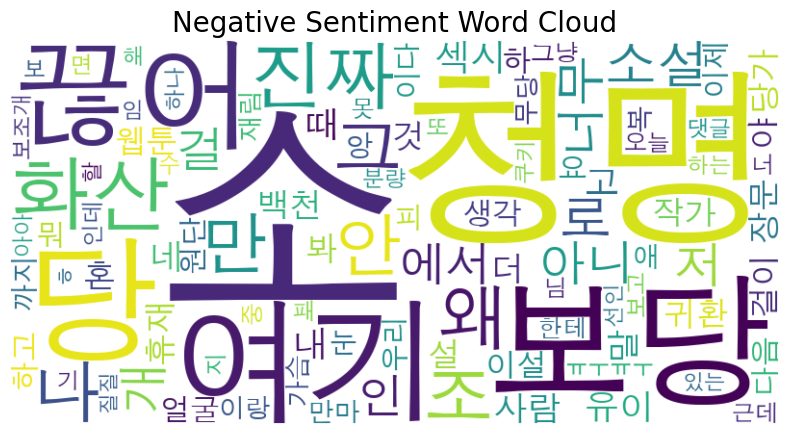

{'소': 603, '청명': 501, '보당': 248, '당': 226, '여기': 226, '끊어': 195, '화산': 170, '진짜': 142, '왜': 140, '안': 130, '조': 125, '그': 121, '만': 119, '나': 119, '소설': 117, '개': 116, '로': 115, '너무': 111, '저': 101, '걸': 98, '아니': 95, '에서': 90, '인': 89, '섹시': 87, '때': 83, '내': 81, '네': 76, '유이': 76, '말': 75, '고': 74, '사람': 71, '것': 68, '더': 67, '귀환': 66, '백천': 66, '설': 66, '야': 66, '휴재': 65, '봐': 65, '장문': 64, '혼': 64, '당가': 63, '작가': 62, '웹툰': 61, '걸이': 61, '이설': 61, '얼굴': 59, '하': 59, '뭐': 59, '생각': 58, '하고': 58, '요': 57, '다음': 57, '원단': 57, '이다': 55, '이제': 55, '까지': 53, '우리': 53, '애': 52, '복': 52, '앙': 52, '눈': 51, '피': 51, '이랑': 51, '가슴': 50, '재림': 50, '만마': 50, '무당': 50, '한테': 49, '그냥': 48, '못': 47, '지': 45, '님': 45, '근데': 44, '또': 44, '면': 44, '너': 44, '패': 43, '오늘': 42, '보고': 42, '중': 41, '인데': 41, '하는': 40, '기': 40, '보조개': 40, 'ㅠㅜㅠㅜ': 40, '선인': 40, '분량': 39, '댓글': 39, '아아': 39, '쿠키': 38, '임': 37, '할': 37, '해': 36, '수': 35, '하나': 35, '보': 35, '있는': 35, 'ㅎ': 35, '질질': 34}


In [18]:
# 긍정 및 부정 감정에 대한 Word Cloud 생성
create_wordcloud(negative_word_freq, 'Negative Sentiment Word Cloud')
print(negative_word_freq)